In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from utilities.imports import *

In [3]:
dataset_path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
transforms = [make_rgb, ResizedFixed(128), to_byte_tensor, to_float_tensor]
bs=128
loss_function = F.cross_entropy
num_filters = [32,64,128,256,512]
num_channels =3
num_categories = 10
callback_funcs = [partial(AvgStatsCallback, accuracy), CudaCallback, partial(IndependentVarBatchTransformCallback, normalize_imagenette)]
image_list = ImageList.from_files(dataset_path, tfms=transforms)
split_data = SplitData.split_by_function(image_list, partial(grandparent_splitter, valid_name="val"))
labeled_data = label_by_func(split_data, parent_labeler, proc_y=CategoryProcessor())
train_dl = torch.utils.data.DataLoader(labeled_data.train, bs, shuffle = True, num_workers=4)
valid_dl = torch.utils.data.DataLoader(labeled_data.valid, bs*2, shuffle = False, num_workers=4)

#  
[Mixup](https://arxiv.org/pdf/1710.09412.pdf)

- Combining images to strain our loss function on
- Relies on the Beta Distribution for selecting the α parameter
    - if alpha is high: likely to have an equal mix of the given data
    - if alpha is low: likely to have a dominating mix of one of the data
- 3 Main Points of the Paper:
    1. Create two Datasorces, draw a batch <u>from each</u> per iteration
    2. Draw a t-value following the beta distribution given parameter alpha
    3. Mix the two batches with the same t-value
    4. Use one-hot encoded y targets (predictions)

In [4]:
def pytorch_gamma(inp):
    return inp.lgamma().exp() #uses pytorch's log_gamma function, raised wth e

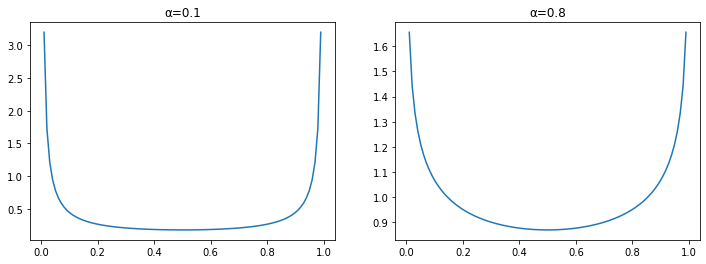

In [5]:
#Beta Distribution:
_,axs = plt.subplots(1,2, figsize=(12,4))
x = torch.linspace(0,1, 100)
for α,ax in zip([0.1,0.8], axs):
    α = tensor(α)
    y = (x**(α-1) * (1-x)**(α-1)) / (pytorch_gamma(α)**2 / pytorch_gamma(2*α))
    ax.plot(x,y)
    ax.set_title(f"α={α:.1}")

### Reductions: How to Return the Loss function results
- Reductions come in 3 main forms:
    1) return the rank 1 tensor
    2) return the sum of the tensor
    3) return the mean of the tensor
- Mixup doesn't use reduction, so ensure it gets turned off
    -this is implemented in the NoReduction Class
    -if Reduction get's used with Mixup, the loss function is completely wrong

In [6]:
class NoReduction():
    """a context manager for storing the implementation of the previous reduction states"""
    
    def __init__(self, loss_function):
        self.loss_function = loss_function
        self.previous_reduction = None
        
    def __enter__(self):
        """manages context of the reduction using the 'with' statement"""
        if hasattr(self.loss_function, 'reduction'):
            self.previous_reduction = getattr(self.loss_function, 'reduction')
            setattr(self.loss_function, 'reduction', 'none')
            return self.loss_function
        return partial(self.loss_function, reduction="none")
    
    def __exit__(self, type, value, traceback):
        if self.previous_reduction is not None:
            setattr(self.loss_function, 'reduction', self.previous_reduction)

# The Mixup Callback
    - must happen after the data is normalized and put on the GPU

In [7]:
from torch.distributions.beta import Beta

def unsqueeze(inp, dimensions):
    """uses torch.unsqueeze() to add a singelton dimension to each dimension"""
    for dimension in dimensions:
        inp = torch.unsqueeze(inp, dimension)
    return inp

def reduced_loss(loss, reduction="mean"):
    """returns the calculated loss with a potentially applied reduction
    
        Defaults to a mean reduction applied to the loss
    """
    return loss.mean() if reduction == "mean" else loss.sum() if reduction =="sum" else loss

In [8]:
# class Mix_Up(Callback):
#     _order = 90 #arbitrary late order, ensures calling after Normalization and Cuda Callbacks
    
#     def __init__(self, alpha:float=0.4):
#         """alpha: a float representing the portion of each data input to use
#         mixup paper defines a default alpha of 0.4"""
#         self.distribution = torch.distributions.beta.Beta(tensor([alpha], tensor[alpha]))
        
#     def begin_fit(self):
#         self.prev_loss_func = self.run.loss_func
#         self.run.loss_func = self.loss_func
        
#     def begin_batch(self):
#         if not self.in_train: return #only mixup things in training
#         #take a sample the beta distribution with the y-batch and put it on the same device as the x-batch
#         gamma = self.distribution.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
#         #1-gamma ensures we create consistently different images
#         gamma = torch.stack([gamma, 1-gamma], 1) #stack the gamma float values
#         self.gamma = unsqueeze(gamma.max(1)[0], (1,2,3)) #get the highest between gamma and 1 - gamma,
#         shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device) #shuffles which data inputs to use from the 2 datasets
#         xb1 = self.xb[shuffle]
#         self.yb1 = self.yb[shuffle]
#         self.run.xb = lin_comb(self.xb, xb1, self.gamma) #replace the x-batch
#     def after_fit(self):
#         self.run.loss_func = self.prev_loss_func
        
#     def loss_func(self, prediction, y_batch):
#         if not self.in_train: return self.prev_loss_func(prediction, y_batch)
#         with NoReduction(self.prev_loss_func) as loss_func:
#             first_loss = loss_func(pred, yb)
#             second_loss = loss_func(pred, self.yb1)
#         loss = lin_comb(first_loss, second_loss, self.gamma)
#         return reduced_loss(loss, getattr(self.prev_loss_func, 'reduction', 'mean')) #reduce the loss using the mean
#export
class Mix_Up(Callback):
    _order = 90 #Runs after normalization and cuda
    def __init__(self, α:float=0.4): self.distrib = Beta(tensor([α]), tensor([α]))
    
    def begin_fit(self): self.old_loss_func,self.run.loss_function = self.run.loss_function,self.loss_func
    
    def begin_batch(self):
        if not self.in_train: 
            return #Only mixup things during training
        λ = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        λ = torch.stack([λ, 1-λ], 1)
        self.λ = unsqueeze(λ.max(1)[0], (1,2,3))
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1,self.yb1 = self.xb[shuffle],self.yb[shuffle]
        self.run.xb = lin_comb(self.xb, xb1, self.λ)
        
    def after_fit(self): self.run.loss_function = self.old_loss_func
    
    def loss_func(self, pred, yb):
        if not self.in_train: return self.old_loss_func(pred, yb)
        with NoReduction(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
        loss = lin_comb(loss1, loss2, self.λ)
        return reduced_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))

In [9]:
callback_funcs.append(Mix_Up) #add Mix Up to our call backs
model, runner = get_model_runner(num_filters, num_channels, num_categories, train_dl, valid_dl, conv_layer, cbs_in=callback_funcs)

In [11]:
runner.fit(1, model, optim.SGD(model.parameters(), lr=0.4, momentum=0.9), loss_function, train_dl, valid_dl)

train: [3.7323453506178055, tensor(0.1389, device='cuda:0')]
valid: [38.699430732484075, tensor(0.1144, device='cuda:0')]
